# ПРОГНОЗИРОВАНИЕ ВРЕМЕННЫХ РЯДОВ НА ОСНОВЕ LSTM-СЕТЕЙ
---
Кабанов Евгений, РИМ-281226

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (13,8)

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

Using TensorFlow backend.


Change here params of model

(число нейронов в слоях, общая структура, коэффициенты Dropout, число предыдущих точек для прогноза, число наблюдений для оубчения)

In [111]:
FUNCTION_SIZE = len(F) # 174

PREDICT_POINTS = 24 # min 24

PAST_POINTS = 48
TRAINING_SIZE = FUNCTION_SIZE - PREDICT_POINTS
NEURONS_IN_LAYERS = 44

EPOCHS_COUNT = 97

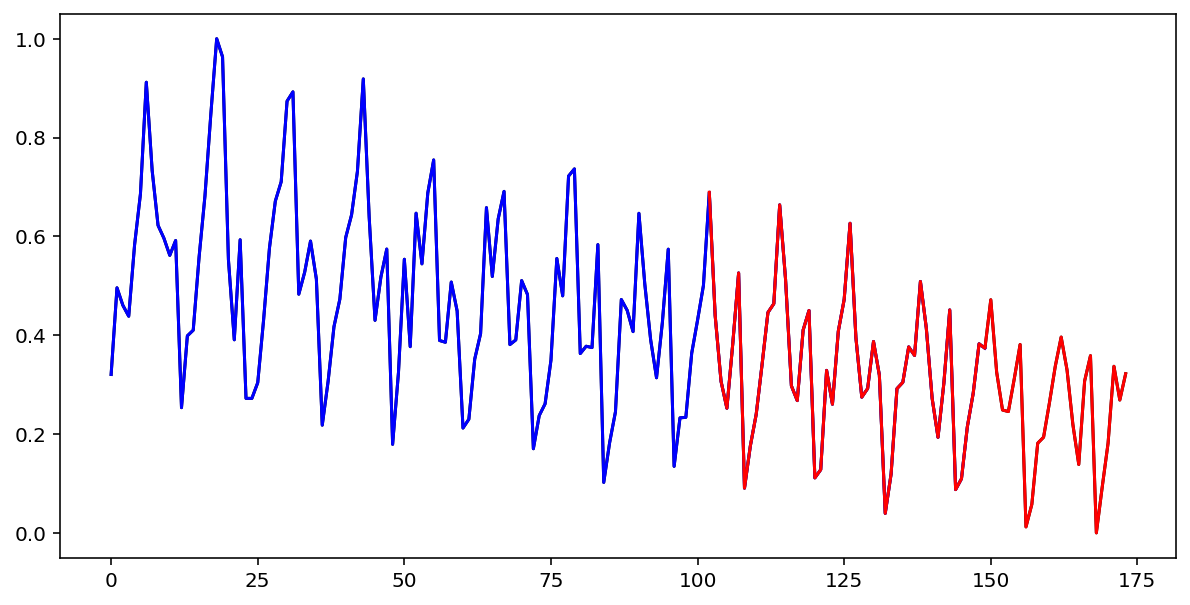

In [112]:
file = h5py.File('Fort.mat', 'r') 
data = file.get('Fort')
Fort = np.array(data)

F = Fort
scaler = MinMaxScaler(feature_range=(0, 1)) 

F = scaler.fit_transform(F)
F_tr = F[:TRAINING_SIZE]
F_test = F[TRAINING_SIZE-PAST_POINTS:]

plt.figure(figsize = (10, 5))
plt.plot(F, 'k') 
plt.plot(np.r_[:TRAINING_SIZE],F_tr, 'b') 
plt.plot(np.r_[TRAINING_SIZE-PAST_POINTS:FUNCTION_SIZE],F_test, 'r') 
plt.show()

In [113]:
from keras.preprocessing.sequence import TimeseriesGenerator 
data_gen = TimeseriesGenerator(F_tr, F_tr, length=PAST_POINTS, sampling_rate=1, batch_size=TRAINING_SIZE)
batch_0 = data_gen[0]
x, y = batch_0 # вход и обучающий выход для сети
print(x.shape) # 144 точки обучения, прогноз 1 точки по 6 прошлым
xx=np.reshape(x, (x.shape[0], 1, x.shape[1]))
yy=y
print(xx.shape) #меняемместамиразмерности
print(yy.shape) #

(102, 48, 1)
(102, 1, 48)
(102, 1)


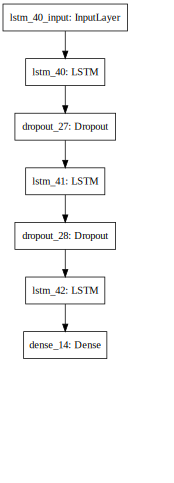

In [114]:
import keras
from IPython.display import SVG
from keras.utils import plot_model
import pydot as pyd
from keras.utils.vis_utils import model_to_dot
keras.utils.vis_utils.pydot = pyd

def visualize_model(model):
  return SVG(model_to_dot(model).create(prog='dot', format='svg'))

model = Sequential()
model.add(LSTM(units=NEURONS_IN_LAYERS, return_sequences=True, input_shape=(1, PAST_POINTS))) 
model.add(Dropout(0.2))
model.add(LSTM(units=NEURONS_IN_LAYERS, return_sequences=True)) 
model.add(Dropout(0.2))
model.add(LSTM(units=NEURONS_IN_LAYERS))
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

visualize_model(model)

In [115]:
model.fit(xx, yy, epochs = EPOCHS_COUNT) # 100 эпох по 144 точки

Epoch 1/97
102/102 [==============================] - 1s 12ms/step - loss: 0.1703
Epoch 2/97
102/102 [==============================] - 0s 174us/step - loss: 0.1535
Epoch 3/97
102/102 [==============================] - 0s 171us/step - loss: 0.1343
Epoch 4/97
102/102 [==============================] - 0s 176us/step - loss: 0.1117
Epoch 5/97
102/102 [==============================] - 0s 163us/step - loss: 0.0839
Epoch 6/97
102/102 [==============================] - 0s 163us/step - loss: 0.0519
Epoch 7/97
102/102 [==============================] - 0s 189us/step - loss: 0.0321
Epoch 8/97
102/102 [==============================] - 0s 197us/step - loss: 0.0302
Epoch 9/97
102/102 [==============================] - 0s 175us/step - loss: 0.0322
Epoch 10/97
102/102 [==============================] - 0s 163us/step - loss: 0.0242
Epoch 11/97
102/102 [==============================] - 0s 162us/step - loss: 0.0237
Epoch 12/97
102/102 [==============================] - 0s 164us/step - loss: 0.0270
Ep

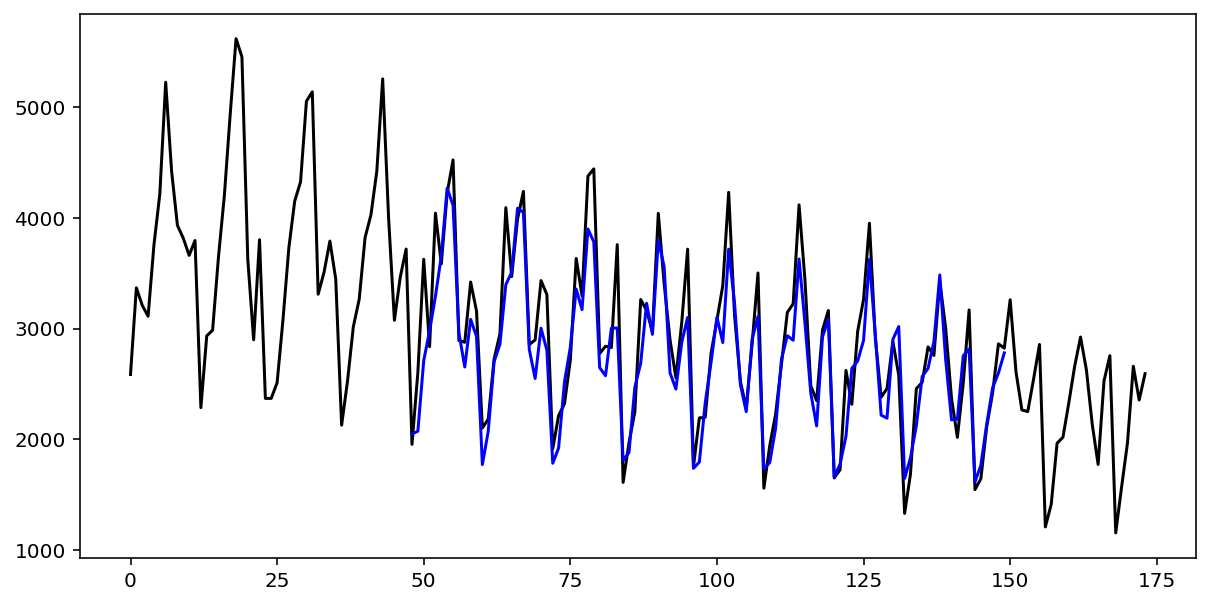

In [116]:
trainPredict = model.predict(xx)
trainPredict = scaler.inverse_transform(trainPredict) 
plt.figure(figsize = (10, 5))
plt.plot(Fort, 'k')
plt.plot(np.r_[PAST_POINTS:TRAINING_SIZE],trainPredict, 'b')
plt.show()

In [117]:
data_gen = TimeseriesGenerator(F_test, F_test, length=PAST_POINTS, sampling_rate=1, batch_size=TRAINING_SIZE)
batch_0 = data_gen[0]
x, y = batch_0
xx=np.reshape(x, (x.shape[0], 1, x.shape[1]))
yy = y
print(xx.shape) # прогноз на 24 точки по 6 наблюдениям print(yy.shape) #

(24, 1, 48)


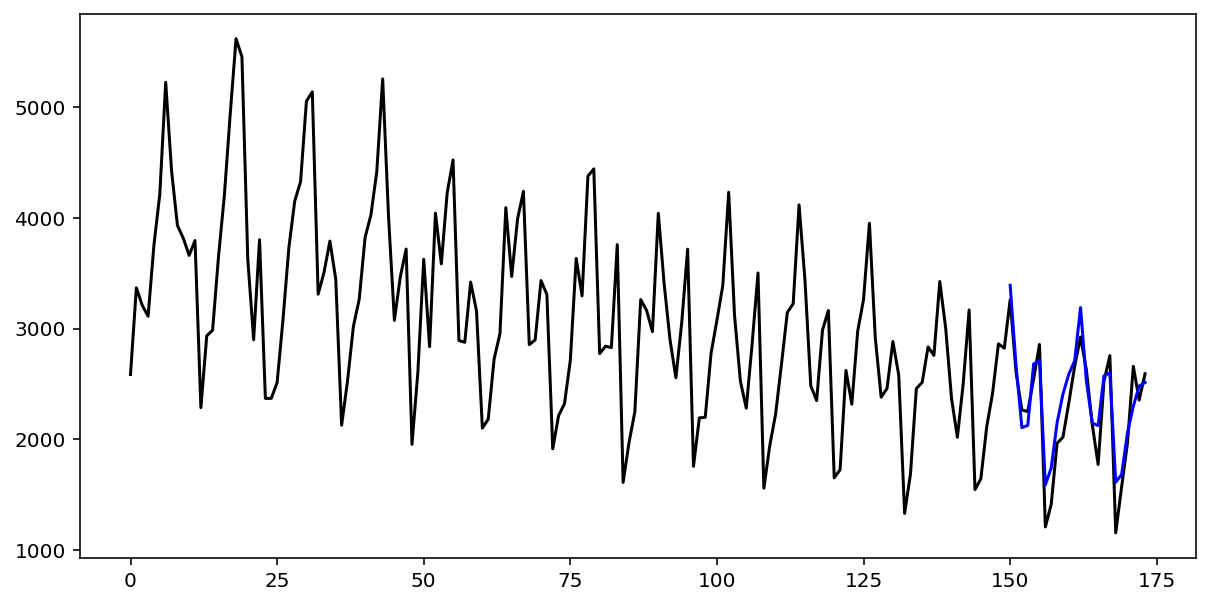

In [118]:
testPredict = model.predict(xx)
testPredict = scaler.inverse_transform(testPredict)
plt.figure(figsize = (10, 5))
plt.plot(Fort, 'k') 
plt.plot(np.r_[TRAINING_SIZE:TRAINING_SIZE + PREDICT_POINTS],testPredict, 'b')
plt.show()